Реализуем градиентный спуск для задачи поиска оптимальных коэффициентов в MSE регрессии!

In [313]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Имеем 1000 объектов и 10 признаков у каждого (+таргет)!

Обучим модель линейной регрессии:

$$
a(x) = \beta_1 d_{1} + \beta_2 d_{2} + \beta_3 d_{3} + \beta_4 d_{4} + \beta_5 d_{5} + \beta_6 d_{6} + \beta_7 d_{7} + \beta_8 d_{8} + \beta_9 d_{9} + \beta_{10} d_{10} + \beta_0
$$

Которая минимизирует MSE:

$$
Q(a(X), Y) = \sum_i^{1000} (a(x_i) - y_i)^2
$$

In [314]:
data = pd.read_csv('data.csv')

data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target
0,0.113768,0.930064,0.330528,0.010987,0.265703,0.699462,0.058465,0.431643,0.650958,0.751820,30.147094
1,0.380048,0.485946,0.870232,0.473401,0.454516,0.500864,0.471723,0.234329,0.072982,0.008372,21.424402
2,0.768462,0.217706,0.727438,0.718377,0.452155,0.434638,0.043989,0.972489,0.450133,0.378157,31.422056
3,0.606637,0.604335,0.540332,0.491236,0.325632,0.206348,0.825767,0.332475,0.955518,0.162811,31.308588
4,0.119770,0.469718,0.632829,0.504207,0.238259,0.452457,0.775360,0.174262,0.117621,0.218883,23.322751


Обучим коэффициенты линейной регрессии с помощью библиотеки <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html"> **sklearn** </a>

Отдельно выведем оценку свободного коэффициента  ($\beta_0$ при $d_0 = 1$)

In [315]:
from sklearn.linear_model import LinearRegression

### Your code is here
model = LinearRegression()
X = data.drop(['target'], axis=1)
Y = data['target']
model.fit(X, Y)

LinearRegression()

In [316]:
model.coef_

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [317]:
model.intercept_

4.373157038707134

Теперь вам необходимо реализовать класс для оптимизации коэффициентов линейной регрессии МНК.
Подразумевается, что на вход алгоритм будет принимать следующие параметры:

- 2 pandas датафрейма **samples** и **targets**, содержащих матрицу объектов и ветор ответов соответственно
- значение **learning rate**, который корректирует длину вектора-градиента (чтобы он не взорвался)
- значение **threshold**'а для критерия останова (когда мы считаем, что мы сошлись к оптимуму)
- параметр **copy**, который позволяет либо делать изменения in-place в датафрейме, подающимся в класс, если изменения матрицы объектов в принципе при обучении имеются. Или же копировать объект при инициализации класса и возвращать новый объект, если требуется.

Он будет состоять из следующих важных компонент-методов:

- **add_constant_feature**: добавляет колонку с названием *constant* из единичек к переданному датафрейму **samples**. Это позволяет оценить свободный коэффициент $\beta_0$.

- **calculate_mse_loss**: вычисляет при текущих весах **self.beta** значение среднеквадратической ошибки.

- **calculate_gradient**: вычисляет при текущих весах вектор-градиент по функционалу.

- **iteration**: производит итерацию градиентного спуска, то есть обновляет веса модели, в соответствии с установленным **learning_rate = $\eta$**: $\beta^{(n+1)} = \beta^{(n)} - \eta \cdot \nabla Q(\beta^{(n)})$

- **learn**: производит итерации обучения до того момента, пока не сработает критерий останова обучения. В этот раз критерием останова будет следующее событие: во время крайней итерации изменение в функционале качества модели составило значение меньшее, чем **self.threshold**. Иными словами, $|Q(\beta^{(n)}) - Q(\beta^{(n+1)})| < threshold$.

P.S. установите в **__init__** аттрибут экземпляра с названием **iteration_loss_dict**, который будет устроен следующим образом: на каждой итерации мы будем добавлять в словарь пару ключ-значение, где ключем будет номер итерации $n$, а значением - среднеквадратическая ошибка в точке $\beta^{(n)}$. Это пригодится нам в будущем для визуализации.

### Hint: пример вычисления производной

$$
Q(a, X) = \frac{1}{N}\cdot\sum_{i=1}^N (\beta_1 \cdot d_{i1} + ... + \beta_n \cdot d_{in} - y_i)^2
$$

Выше - минимизируемая функция. Она зависит от n переменных: $\beta_1, ..., \beta_n$. Вектор-градиент - матрица с одной строчкой, состоящей из производных 1го порядка по всем переменным.

$$
\nabla Q(a, X) = (Q'_{\beta_1} \;\;\; Q'_{\beta_2} \;\;\; ... \;\;\; Q'_{\beta_{n-1}}  \;\;\;  Q'_{\beta_n})
$$

Пример вычисления производной по первой переменной:

$$
Q'_{\beta_1} = \frac{2}{N} \cdot \sum_{i=1}^N d_{i1} (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

Скажем, для нашего датасета X, Y вычислим эту саму производную при начальных единичных коэффициентах $\beta_{start} = (1 \;\;\; 1 \;\;\; ...)$

Получим для каждого объекта в начале выражение из скобочек: 
$$
\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i
$$

In [318]:
### Инициализируем точку для коэффициентов в виде вектора из единичек
initial_betas = np.ones(X.shape[1])

### Получим выражение выше для каждого объекта. 
### Для этого скалярно перемножим строчки из X на наши beta

scalar_value = np.dot(X, initial_betas.reshape(-1, 1)).ravel()
scalar_value = (scalar_value - Y).values

Теперь полученное значение для каждого объекта умножим на соответствующее значение признака $d_1$:

$$
d_{i1} \cdot (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

In [319]:
### Возьмем столбик со значениями 1 признака

d_i1 = X.values[:, 0]

### Умножим каждый объект на соответствующее значение признака
scalar_value = scalar_value * d_i1

In [320]:
### Наконец, умножим все на 2 и усреднимся, 
### чтобы получить значение производной по первому параметру

2 * np.mean(scalar_value)

-27.62384887912409

In [321]:
from sklearn.metrics import mean_squared_error

### Эта логика поможем Вам при реализации класса!

In [322]:
class GradientDescentMse:
    """
    Базовый класс для реализации градиентного спуска в задаче линейной МНК регрессии 
    """

    def __init__(self, samples: pd.DataFrame, targets: pd.DataFrame,
                 learning_rate: float = 1e-3, threshold = 1e-6, copy: bool = True):
        """
        :param samples: матрица объектов
        :param targets: вектор (матрица с 1 столбцом) ответов
        :param learning_rate: параметр learning_rate для корректировки нормы градиента
        :param threshold: величина, меньше которой изменение в loss-функции означает 
        :param copy: копировать сэмплы или делать изменения in-place (см. add_constant_feature)
        """
        ### Your code is here
        if copy:
            self.samples = samples.copy()
        else:
            self.samples = samples
        self.targets = targets
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.beta = np.ones(self.samples.shape[1])
        self.iteration_loss_dict = {}
        
    def add_constant_feature(self):
        """
        Метод для создания константной фичи в матрице объектов samples
        """
        ### Your code is here
        self.samples['beta'] =  1 #np.ones((self.samples.shape[0],1))

        
    def calculate_mse_loss(self) -> float:
        """
        Метод для расчета среднеквадратической ошибки
        
        :return: среднеквадратическая ошибка при текущих весах модели : float
        """
        ### Your code is here
        preds = np.dot(self.samples, self.beta)
        mse = mean_squared_error(self.targets, preds)
        return mse

    def calculate_gradient(self) -> np.ndarray:
        """
        Метод для вычисления вектора-градиента
        
        :return: вектор-градиент, т.е. массив, содержащий соответствующее количество производных по каждой переменной : np.ndarray
        """
        ### Your code is here

        scalar_value = np.dot(self.samples, self.beta.reshape(-1, 1)).ravel()
        scalar_value = (scalar_value - self.targets).values
        gradient = np.array([])
        for i in range(self.samples.shape[1]):
            d_i = self.samples.values[:, i]
            scalar_v = scalar_value * d_i
            scalar_v = 2 * np.mean(scalar_v)
            gradient = np.append(gradient, scalar_v)
        return gradient
    
    def iteration(self):
        """
        Обновляем веса модели в соответствии с текущим вектором-градиентом
        """
        ### Your code is here
        self.beta = self.beta -  self.learning_rate * self.calculate_gradient()
        
    def learn(self):
        """
        Итеративное обучение весов модели до срабатывания критерия останова
        """
        ### Your code is here
        
        step, i = self.threshold, 0
        self.iteration_loss_dict[i] = self.calculate_mse_loss() 
        while self.threshold <= step:
            self.iteration()
            #q_prev = (((np.dot(self.samples, prev) - self.targets))**2).mean()
            i += 1
            self.iteration_loss_dict[i] =  self.calculate_mse_loss() 
            #q_next= self.calculate_mse_loss()#(((np.dot(self.samples, self.beta) - self.targets))**2).mean()
            #step = np.abs(q_prev - q_next) 
            step = np.abs(self.iteration_loss_dict[i-1] - self.iteration_loss_dict[i])
            
        

Обучим коэффициенты линейной модели с помощью реализованного нами градиентного спуска, не забыв добавить свободную переменную. Получились ли такие же коэффициенты, как и при использовании **LinearRegression** из **sklearn**? Если нет, то почему они отличаются, на Ваш взгляд, и сильно ли?

In [323]:
GD = GradientDescentMse(samples=X, targets=Y)
GD.add_constant_feature()
GD.learn()

In [324]:
print('Веса модели при переменных d0, d1, ..., d10 равны соответственно: \n\n' + str(GD.beta))

Веса модели при переменных d0, d1, ..., d10 равны соответственно: 

[0.88733305 1.90100713 2.88063607 3.87662612 4.89623507 5.89126182
 6.89254811 7.90311947 8.87580109 9.86109585 4.94854733]


In [325]:
print('Веса модели при переменных d0, d1, ..., d10 равны соответственно: \n\n' + str(np.around(GD.beta,2)))

Веса модели при переменных d0, d1, ..., d10 равны соответственно: 

[0.89 1.9  2.88 3.88 4.9  5.89 6.89 7.9  8.88 9.86 4.95]


In [326]:
GD.iteration_loss_dict[0]

682.668858746845

Попробуйте теперь изменить значения **learning_rate** и/или **threshold**. Например, установите длину шага $\eta = 1$. Что произошло и почему такое возможно?

In [327]:
# ### Your code is here
# GD1 = GradientDescentMse(samples=X, targets=Y, learning_rate=1)
# GD1.add_constant_feature()
# GD1.learn()
# print('Веса модели при переменных d0, d1, ..., d10 равны соответственно: \n\n' + str(GD1.beta))

В машинном обучении зачастую исследуют так называемые **траектории обучения** (или **learning paths**). Это графики, показывающие, как во время обучения при каждой следующей итерации изменялось значение минимизируемого функционала. Постройте такие траектории для различных **learning rate**'ов и **threshold**'ов. Советуем использовать для этого разобранный на занятиях **add_subplot** метод. 

Возьмите следующие **threshold**'ы: 1e-2, 1e-3, 1e-4, 1e-5

И следующие значения **learning rate**'а: 1e-1, 5e-2, 1e-2, 5e-3, 1e-3

У вас должен получиться примерно такой график (см. ниже, значения среднеквадратической ошибки мы намеренно замазали оранжевыми квадратиками, чтобы не спойлерить вам результаты).

Как и подобает хорошим Data Scientist'ам, не забывайте подписывать графики, оси, а так же делать элементы ваших визуализаций читаемыми и видимыми. Советуем пересмотреть методы и параметры форматирования из лекции.

При какой комбинации **threshold** - **learning rate** из возможных предложенных выше, получается достигнуть меньшего значения нашей минимизируемой функции? Запишите каждой из значений в легенде на графиках.


In [328]:
### Your code is here
# GD1 = GradientDescentMse(samples=X, targets=Y, learning_rate = 1e-1, threshold = 1e-2)
# GD1.add_constant_feature()
# GD1.learn()

# GD2 = GradientDescentMse(samples=X, targets=Y, learning_rate = 5e-2, threshold = 1e-3)
# GD2.add_constant_feature()
# GD2.learn()

# GD3 = GradientDescentMse(samples=X, targets=Y, learning_rate = 1e-2, threshold = 1e-4)
# GD3.add_constant_feature()
# GD3.learn()

# GD4 = GradientDescentMse(samples=X, targets=Y, learning_rate = 1e-3, threshold = 1e-4)
# GD4.add_constant_feature()
# GD4.learn()

In [329]:
threshold = [1e-2, 1e-3, 1e-4, 1e-5]
learning_rate = [1e-1, 5e-2, 1e-2, 5e-3, 1e-3]
N = len(threshold)
M = len(learning_rate)
losses = [ [0]*M for i in range(N)]
for i, t in enumerate(threshold):
    for j, lr in enumerate(learning_rate):
        GD1 = GradientDescentMse(samples=X, targets=Y, learning_rate=lr, threshold=t)
        GD1.add_constant_feature()
        GD1.learn()
        losses[i][j] = GD1.iteration_loss_dict

In [355]:
y_last = []
for i in range(N):
    for j in range(M):       
        print(i, j, list(losses[i][j].values())[-1])

0 0 0.4355939097666294
0 1 0.7574160572907992
0 2 3.1734848168652996
0 3 5.849467813066771
0 4 7.021393364861748
1 0 0.08744650549453238
1 1 0.14183733475864319
1 2 0.44309740918027624
1 3 0.7697187362545037
1 4 3.185525472571805
2 0 0.01063618687691517
2 1 0.02123948100772671
2 2 0.08813433782587322
2 3 0.1430820823862407
2 4 0.44455059805440655
3 0 0.0010623860912254012
3 1 0.002141774334639189
3 2 0.010723949538996354
3 3 0.021323411681452627
3 4 0.08819375563546872


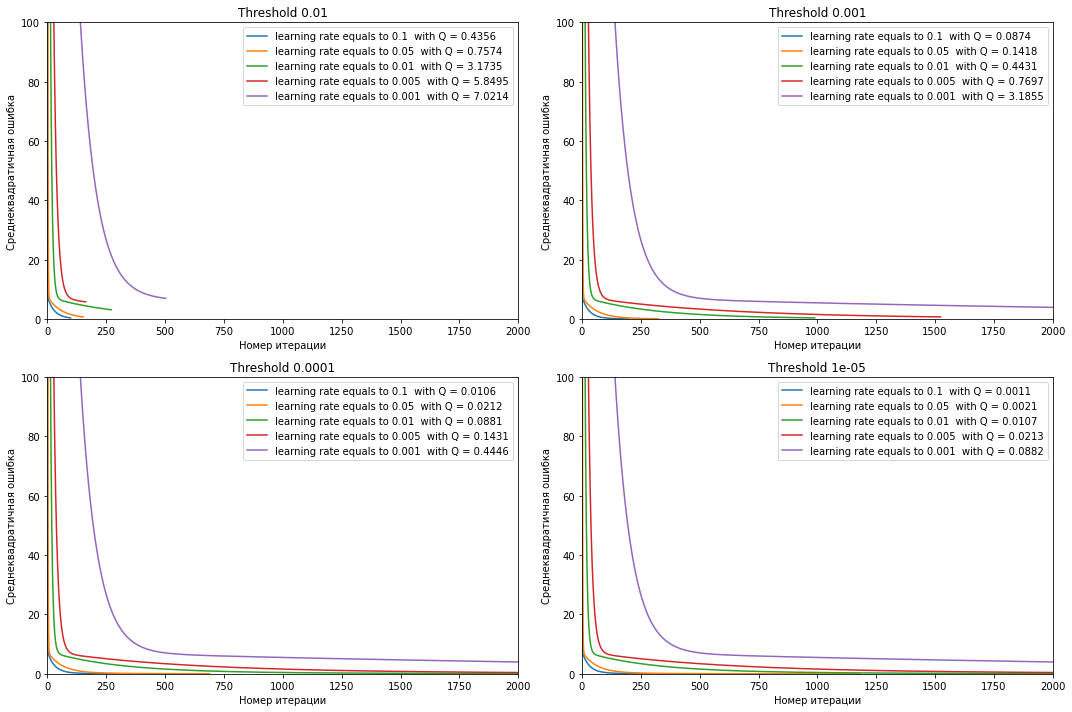

In [356]:
fig = plt.figure()

fig.set_size_inches(15, 10)
k = 0
size = N//2
for i in range(N):
    ax = fig.add_subplot(size, size, i+1)
    lgnd = []
    for j in range(M):       
        x = list(losses[i][j].keys())
        y = list(losses[i][j].values())
        plt.plot(x, y)
        
        #plt.xticks(xt, yt)
        lgnd.append('learning rate equals to ' + str(learning_rate[j]) + '  with Q = ' + str(round(y[-1], 4)))
    plt.ylim((0,100))
    plt.xlim((0,2000))
    plt.title('Threshold ' + str(threshold[i]))
    plt.xlabel('Номер итерации')
    plt.ylabel('Среднеквадратичная ошибка')
    plt.legend(lgnd)
fig.tight_layout()
plt.show()     